# Title

[Free Form Description]

**Resources**

- [The NRC Valence, Arousal, and Dominance Lexicon](http://saifmohammad.com/WebPages/nrc-vad.html)
- [Blogpost on scraping song lyrics](https://chrishyland.github.io/scraping-from-genius/) - Thanks to Chris Hyland for this!
- [Genius API documentation](https://docs.genius.com/#/getting-started-h1) 


**Data Input:**

- `data/processed/audio_data.csv`: DataFrame of all CC tracks with "Sonic Brutality Index" (from notebook 1)
- `data/raw/NRC-VAD-Lexicon.txt`: Data of approx 20'000 words with valence, arousal and dominance scores

**Data Output:**

- `data/processed/wbi_lexicon.csv`: DataFrame containing 20'000 words with their corresponding 'Word Brutality Index"

**Changes**

- 2019-02-18: Start project
- 20-02-25: Complete audio analysis



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Load-and-Prepare-Lexicon" data-toc-modified-id="Load-and-Prepare-Lexicon-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and Prepare Lexicon</a></span></li><li><span><a href="#Scrape-and-Prepare-Lyrics" data-toc-modified-id="Scrape-and-Prepare-Lyrics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scrape and Prepare Lyrics</a></span></li><li><span><a href='#Define-and-calculate-"Lyrical-Brutality-Index"' data-toc-modified-id='Define-and-calculate-"Lyrical-Brutality-Index"-4'><span class="toc-item-num">4&nbsp;&nbsp;</span>Define and calculate "Lyrical Brutality Index"</a></span></li><li><span><a href="#Bring-it-all-together:-Calculate-'Total-Brutality-Index'" data-toc-modified-id="Bring-it-all-together:-Calculate-'Total-Brutality-Index'-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bring it all together: Calculate 'Total Brutality Index'</a></span><ul class="toc-item"><li><span><a href="#Normalize-LBI-and-SBI" data-toc-modified-id="Normalize-LBI-and-SBI-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Normalize LBI and SBI</a></span></li></ul></li><li><span><a href="#Calculate-TBI" data-toc-modified-id="Calculate-TBI-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculate TBI</a></span></li></ul></div>

---

## Import libraries

In [1]:
# Import libraries

from pprint import pprint
import re
import requests
import urllib.request
import urllib.parse
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.preprocessing import minmax_scale
import credentials # file where credentials for genius API are stored

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer  # default lemmatizer

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('raph-base')
import seaborn as sns 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load and Prepare Lexicon
The NRC Valence, Arousal, and Dominance (VAD) Lexicon includes a list of more than 20,000 English words and their valence, arousal, and dominance scores. For a given word and a dimension (V/A/D), the scores range from 0 (lowest V/A/D) to 1 (highest V/A/D). Reading the lexicon into a Pandas DataFrame requires a little tweaking / cleaning first.

In [2]:
with open('data/raw/NRC-VAD-Lexicon.txt') as file:
    data_list = []
    line = file.readline()
    while line:
        data_list.append(str(line))
        line = file.readline()

In [3]:
# Check results
data_list[:5]

['Word\tValence\tArousal\tDominance\n',
 'aaaaaaah\t0.479\t0.606\t0.291\n',
 'aaaah\t0.520\t0.636\t0.282\n',
 'aardvark\t0.427\t0.490\t0.437\n',
 'aback\t0.385\t0.407\t0.288\n']

In [4]:
# Split and clean
data_list2 = [x.replace('\n', '').split('\t') for x in data_list]

In [5]:
vad_lexicon = pd.DataFrame(data_list2[1:], columns=data_list2[0], dtype=float)
vad_lexicon.columns = (col.lower() for col in vad_lexicon.columns)

In [6]:
# Check results ...
display(vad_lexicon.iloc[[1860]])

,word,valence,arousal,dominance
1860,bloodshed,0.048,0.942,0.525


Exactly what we are looking for: low valence, high arousal ... ;-) 

We can also see that `dominance` is quite neutral and probably no feature that will be of further help. To more easily filter and analize for words with a combination of low-valence and high-arousal I will create a new feature `anti-valence` that is (1 - valance). Then we can simply sum the 2 scores to get a `word brutality index (WBI)`. (To land in a range between 0 and 1 we will normalize it using sklearn's minmax_scaler.)

_Note to myself: If I would like to compare with the results of other artists, I would have to use the same scaling factors. This is not implemented yet._

In [7]:
lexicon = vad_lexicon.copy()
lexicon['anti_valence'] = lexicon['valence'].apply(lambda x: 1-x)
wbi = minmax_scale(lexicon['anti_valence'] + lexicon['arousal'])
lexicon['wbi'] = wbi
lexicon.drop(['valence', 'dominance'], axis=1, inplace=True)

In [8]:
# Check results ...
display(lexicon.nlargest(10, 'wbi'))
display(lexicon.loc[lexicon['word'] == 'zombie'])

,word,arousal,anti_valence,wbi
8472,homicide,0.973,0.990,1.000000
11521,murderer,0.960,0.990,0.992746
9854,killer,0.971,0.959,0.981585
20,abduction,0.990,0.938,0.980469
17277,suicidebombing,0.957,0.969,0.979353
11523,murderous,0.940,0.983,0.977679
4366,dangerous,0.941,0.980,0.976562
1035,assassinate,0.969,0.949,0.974888
386,aggresive,0.971,0.941,0.971540
1856,bloodbath,0.971,0.940,0.970982


,word,arousal,anti_valence,wbi
19999,zombie,0.648,0.786,0.704799


Wow, people nowadays definitely seem to be scared a lot more of suicide bombers than of zombies ... how come?

In [9]:
# Visualize distribution of 'wbi'

def show_wbi_distribution(data, percentiles=[80]):
    """Show the value distribution of a list of WBI-scores."""
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(data, color='yellow', bins=30, hist_kws={'edgecolor': 'grey'})
    for percentile in percentiles:
        qvl = plt.axvline(np.percentile(data, percentile) , color='rebeccapurple', linewidth=2.0)
    ax.legend([qvl], [f'Percentiles {percentiles}'], fontsize=10)
    ax.set_title('Overal WBI Distribution', fontsize=12)
    ax.set_xlabel('Word Brutality Index', fontsize='large')
    ax.set_ylabel('Frequency', fontsize='large');

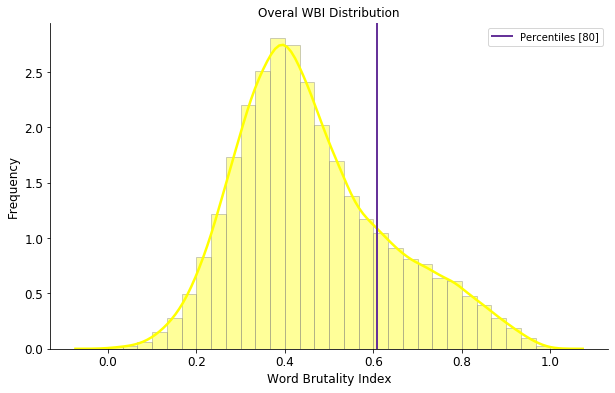

In [10]:
show_wbi_distribution(lexicon['wbi'])

Let's say that the top 20% of WBI scores are the 'brutal' words. This will be the threshold we will use when calculating the "Lyrical Brutality Index" later on. The threshold is:

In [11]:
wbi_threshold = np.percentile(lexicon['wbi'], 80)
print("WBI-threshold for 'brutal' words:", round(wbi_threshold, 3))

WBI-threshold for 'brutal' words: 0.608


In [12]:
# Save a copy of the lexicon
lexicon.to_csv('data/processed/wbi_lexicon_cc.csv', index=False)

In [13]:
# Create a lookup dictionary for 'word: wbi'
wbi_lookup = dict(zip(lexicon['word'], lexicon['wbi']))
print(list(wbi_lookup.items())[:5])

[('aaaaaaah', 0.5334821428571428), ('aaaah', 0.52734375), ('aardvark', 0.4977678571428571), ('aback', 0.4748883928571428), ('abacus', 0.33203125)]


## Scrape and Prepare Lyrics

Scrape all Cannibal Corpse lyrics from the genius API.

In [14]:
base = "https://api.genius.com"
genius_token = credentials.genius_token

def get_json(path, params=None, headers=None):
    '''Send request and get response in json format.'''

    # Generate request URL
    requrl = '/'.join([base, path])
    token = f"Bearer {genius_token}"
    if headers:
        headers['Authorization'] = token
    else:
        headers = {"Authorization": token}
    # Get response object from querying genius api
    response = requests.get(url=requrl, params=params, headers=headers)
    response.raise_for_status()
    return response.json()

In [15]:
# Get artist ID

name = "Cannibal Corpse"

def get_artist_id(artist_name):
    '''Search Genius API for artist ID via artist name.'''

    search = "/search?q="
    query = base + search + urllib.parse.quote(artist_name)
    request = urllib.request.Request(query)
    request.add_header("Authorization", "Bearer " + genius_token)
#     request.add_header("User-Agent", "")  
    response = urllib.request.urlopen(request, timeout=3)
    raw = response.read()
    data = json.loads(raw)['response']['hits']
    
    return (data[0]['result']['primary_artist']['id'])

In [16]:
artist_id = get_artist_id(name)
print(artist_id)

41863


In [17]:
def get_songlist(artist_id):
    '''Get all the song ids and titles from an artist in form of a dict.'''
    current_page = 1
    next_page = True
    songs = [] # to store final song ids
    while next_page:
        path = f"artists/{artist_id}/songs/"
        params = {'page': current_page} # the current page
        data = get_json(path=path, params=params) # get json of songs
        page_songs = data['response']['songs']
        if page_songs:
            # Add all the songs of current page
            songs += page_songs
            # Increment current_page value for next loop
            current_page += 1
            print(f"Page {current_page} finished scraping")
            # If you don't wanna wait too long to scrape, un-comment this
            # if current_page == 2:
            #     break
        else:
            # If page_songs is empty, quit
            next_page = False

    print(f"Song id were scraped from {current_page} pages")

    # Get all the song ids, excluding not-primary-artist songs.
    songlist = {song["id"]: song['title'].lower() for song in songs
                if song["primary_artist"]["id"] == artist_id}

    return songlist

In [18]:
songlist = get_songlist(artist_id)
print(f"\n{list(songlist.items())[:2]}")
print("# of songs:", len(songlist))

Page 2 finished scraping
Page 3 finished scraping
Page 4 finished scraping
Page 5 finished scraping
Page 6 finished scraping
Page 7 finished scraping
Page 8 finished scraping
Page 9 finished scraping
Page 10 finished scraping
Page 11 finished scraping
Song id were scraped from 11 pages

[(764037, 'absolute hatred'), (715726, 'a cauldron of hate')]
# of songs: 187


In [19]:
# Remove songs from live albums (they are lyrical duplicates)
songlist = {id_: title for id_, title in songlist.items() if "live" not in title}
print("# of songs (excluding live performances):", len(songlist))

# of songs (excluding live performances): 174


In [20]:
def connect_lyrics(song_id):
    '''Constructs the path of song lyrics. (Called within next function.)'''

    url = f"songs/{song_id}"
    data = get_json(url)
    # Gets the path of song lyrics
    path = data['response']['song']['path']
    return path

def retrieve_lyrics(song_id):
    '''Retrieves lyrics from html page.'''

    path = connect_lyrics(song_id)
    URL = "http://genius.com" + path
    page = requests.get(URL)
    # Extract the page's HTML as a string
    html = BeautifulSoup(page.text, "html.parser")
    # Scrape the song lyrics from the HTML
    lyrics = html.find("div", class_="lyrics").get_text()
    return lyrics

In [21]:
def scrape_lyrics(songlist):
    """Scrape the lyrics from the songs in a songlist."""
    lyrics_dict = {}
    for song_id, title in tqdm(songlist.items()):
        lyrics_dict[title] = retrieve_lyrics(song_id)  
    return lyrics_dict

In [22]:
lyrics_dict = scrape_lyrics(songlist)

100%|██████████| 174/174 [08:31<00:00,  2.94s/it]


In [23]:
# Print sample
lyrics_dict['absolute hatred']

"\n\nNever leave your nest unguarded\nNext of kin the first to go\nAbsolute hatred cast upon the family\nPayback for the hated one\n\nI am the judge, jury, executioner\nAnd pallbearer all in one\nProcess of elimination\nAffirmative action has just begun\nExpectorate upon your soul\nMalicious devilry is unleashed ten fold\nYou cannot hide\n\nWitness of my stopping power\nReaction time is not enough\nPsychological torment tearing at you sanity\nIt has to be, it must be done\n\nHatred flows, uncontained, feel my wrath\nThrough the death of your entire tribe\n\nHatred flows, uncontained\nI must achieve my revenge through hatred\n\nI've regained my pride\nVictory's mine\nYou cannot hide\nThe footsteps you hear are gonna be mine\n\n"

In [24]:
def process_text(raw_text):
    
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    text = re.sub(r"[^a-zA-Z0-9]", " ", raw_text.lower().strip())
    tokens = word_tokenize(text)
    lemmed = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    lemmed_tokens = [WordNetLemmatizer().lemmatize(w, pos='v') for w in lemmed]  # lemm to verbs, not nouns 
    return lemmed_tokens

**Note:** The lemmatization has a certain effect on the results as for example the words "torture" (V: 0.115, D: 0.878) has not exactly the same values as the word "tortured" (V: 0.062, D: 0.890). But the differences are fairly small and so I will just go on. (I also have destroyed all word combinations, again the effect will probably be small ...)

In [25]:
lyrics_dict_clean = {title: process_text(lyric) for title, lyric in lyrics_dict.items()}
# print one sample
print(lyrics_dict_clean['absolute hatred'])

['never', 'leave', 'nest', 'unguarded', 'next', 'kin', 'first', 'go', 'absolute', 'hatred', 'cast', 'upon', 'family', 'payback', 'hat', 'one', 'judge', 'jury', 'executioner', 'pallbearer', 'one', 'process', 'elimination', 'affirmative', 'action', 'begin', 'expectorate', 'upon', 'soul', 'malicious', 'devilry', 'unleash', 'ten', 'fold', 'hide', 'witness', 'stop', 'power', 'reaction', 'time', 'enough', 'psychological', 'torment', 'tear', 'sanity', 'must', 'do', 'hatred', 'flow', 'uncontained', 'feel', 'wrath', 'death', 'entire', 'tribe', 'hatred', 'flow', 'uncontained', 'must', 'achieve', 'revenge', 'hatred', 'regain', 'pride', 'victory', 'mine', 'hide', 'footstep', 'hear', 'gon', 'na', 'mine']


In [26]:
lyrics_dict_wbi = {}
for title, text in lyrics_dict_clean.items():
    lyrics_dict_wbi[title] = [wbi_lookup[word] for word in text if word in wbi_lookup.keys()]

In [27]:
# print one sample
print(lyrics_dict_wbi['absolute hatred'])

[0.4291294642857142, 0.20256696428571425, 0.6981026785714285, 0.4056919642857142, 0.3928571428571428, 0.4241071428571428, 0.4536830357142857, 0.9146205357142857, 0.4972098214285713, 0.1361607142857143, 0.4854910714285713, 0.2276785714285714, 0.32310267857142855, 0.5150669642857142, 0.5340401785714286, 0.786830357142857, 0.32310267857142855, 0.4408482142857142, 0.8058035714285713, 0.31473214285714285, 0.5396205357142856, 0.4023437499999999, 0.15569196428571425, 0.7907366071428571, 0.6277901785714285, 0.2940848214285714, 0.4776785714285713, 0.5027901785714286, 0.466517857142857, 0.5909598214285714, 0.4352678571428571, 0.6529017857142857, 0.2862723214285714, 0.4866071428571428, 0.8493303571428571, 0.5831473214285714, 0.2762276785714285, 0.4481026785714286, 0.39453124999999994, 0.9146205357142857, 0.25055803571428575, 0.35100446428571425, 0.9475446428571427, 0.8470982142857142, 0.33593750000000006, 0.36328124999999994, 0.9146205357142857, 0.25055803571428575, 0.4481026785714286, 0.31138392

## Define and calculate "Lyrical Brutality Index"



$$Lyrical Brutality Index = \sqrt{(\frac{\text{brutal words}} {\text{number of words}}) * (\frac{\text{number of words}}{\text{duration}})}  =  \sqrt{\frac{\text{brutal words}} {\text{duration}}}$$

In [28]:
# Visualize distribution of wbi scores over the whole text corpus
full_corpus = [score for text in lyrics_dict_wbi.values() for score in text]

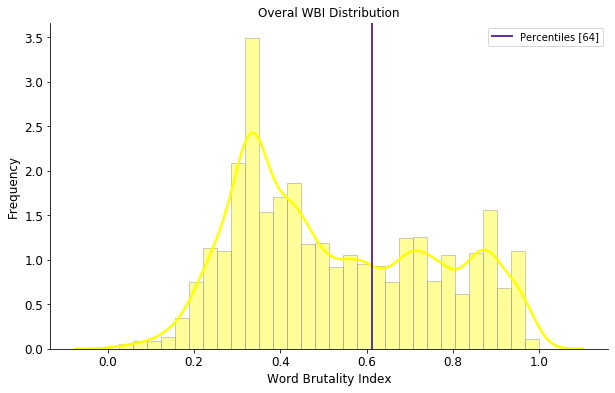

In [29]:
show_wbi_distribution(full_corpus, percentiles=[64])

In [30]:
np.percentile(full_corpus, 64) 

0.6116071428571427

In [31]:
np.percentile(lexicon['wbi'], 75)  

0.5652901785714285

In [32]:
np.sum(lyrics_dict_wbi['absolute hatred'] > wbi_threshold) / len(lyrics_dict_wbi['absolute hatred'])

0.23728813559322035

In [33]:
def calculate_lb_features(text, wbi_treshold=wbi_threshold):
    total_words = len(text)
    brutal_words = np.sum(text > wbi_threshold)
    brutal_prop = brutal_words / total_words
    
    return total_words, brutal_words, brutal_prop

In [34]:
# Create a Dataframe with the lb features
lb_features_dict = {title: calculate_lb_features(text) for title, text in lyrics_dict_wbi.items()}
print(list(lb_features_dict.items())[:2])

[('absolute hatred', (59, 14, 0.23728813559322035)), ('a cauldron of hate', (132, 59, 0.44696969696969696))]


In [35]:
lyric_data = pd.DataFrame(lb_features_dict.keys(), columns=['title'])
lyric_data['total_words'] = lyric_data['title'].apply(lambda x: lb_features_dict[x][0])
lyric_data['brutal_words'] = lyric_data['title'].apply(lambda x: lb_features_dict[x][1])
lyric_data['brutal_prop'] = lyric_data['title'].apply(lambda x: lb_features_dict[x][2])
display(lyric_data.sort_values(['brutal_prop'], ascending=False).head())

,title,total_words,brutal_words,brutal_prop
60,firestorm vengeance,89,56,0.629213
48,dormant bodies bursting,83,52,0.626506
104,perverse suffering,134,82,0.611940
41,demented aggression,109,62,0.568807
102,only one will die,126,69,0.547619


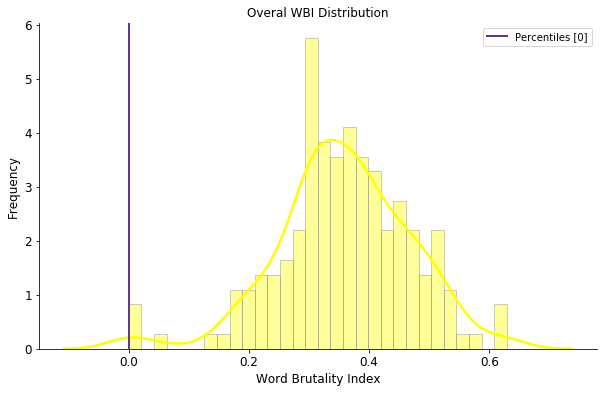

In [36]:
show_wbi_distribution(lyric_data['brutal_prop'], percentiles=[0])

In [37]:
# Look at lyrics with higest proportion of 'brutal' words
lylyrics_dict['firestorm vengeance']

"\n\nVenomous blood courses through our veins\nPoisoned by indignation\nSo much blood on their callous hands\nCruelty their ruination\n\nFirestorm vengeance\nFirestorm vengeance\n\nThey sought to oppress\nUnder duress\nNever thinking of this day\n\nNo cheeks were turned\nNow the bodies burn\nAnd the tyrants writhe in pain\n\nNo mercy for the merciless\nThe time for that has passed\n\nFlagellate before they burn\nThey scream with every lash\n\nRavaging their halls of torture and death\nCraving retribution\nWinds of hatred fan the flames\nReprisal's conflagration\n\nFirestorm vengeance\nFirestorm vengeance\nFirestorm vengeance\n\nSearing heat chars their flesh\nBurning judgment\nPunish them\n\nFurious inferno\nThey cry in pain\nNo mercy\n\nFirestorm\nPayback for their crimes\n\nNo escape from this hell\nThey will burn here\nFlames consume\n\nBodies burnt to the bone\nReduced to coals\nThe oppressors pay\n\nFirestorm\nPersecution ends\nFirestorm\nDespot burn in hell\n\nFirestorm vengeance

In [38]:
# Load the audio data DataFrame to merge it with the lyric data
audio_data = pd.read_csv('data/processed/audio_data.csv')
audio_data['title'] = audio_data['title'].str.lower() 
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 7 columns):
title           144 non-null object
uri             144 non-null object
energy          144 non-null float64
valence         144 non-null float64
danceability    144 non-null float64
sbi             144 non-null float64
duration_sec    144 non-null float64
dtypes: float64(5), object(2)
memory usage: 8.0+ KB


In [40]:
song_data = pd.merge(audio_data, lyric_data, on='title', how='inner')
song_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 133
Data columns (total 10 columns):
title           134 non-null object
uri             134 non-null object
energy          134 non-null float64
valence         134 non-null float64
danceability    134 non-null float64
sbi             134 non-null float64
duration_sec    134 non-null float64
total_words     134 non-null int64
brutal_words    134 non-null int64
brutal_prop     134 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 11.5+ KB


After merging the audio and lyrics data we have 134 songs remaining. None of the ones that could not be matched with the audio data had a particularly high sbi. And only a very few had reasonably high proportion of brutal words.

In [44]:
# Finally calculate the lbi
song_data['lbi'] = song_data['brutal_words'] / song_data['duration_sec']
display(song_data.nlargest(5, 'lbi'))

,title,uri,energy,valence,danceability,sbi,duration_sec,total_words,brutal_words,brutal_prop,lbi
116,puncture wound massacre,spotify:track:6tNy0SL7YeBrTJmDwTjnzA,0.993,0.0377,0.311,0.977529,101.200,142,71,0.500000,0.701581
106,unite the dead,spotify:track:1pG92XKUDXo3FQxzqNaSGH,0.982,0.0954,0.194,0.942506,185.333,164,85,0.518293,0.458634
47,pounded into dust,spotify:track:6jZQyjwjxG1neT2GapMsoz,0.989,0.1240,0.306,0.930787,136.626,112,60,0.535714,0.439155
84,dormant bodies bursting,spotify:track:0G074Tus7GLgG5Pr5IpsA0,0.997,0.0579,0.392,0.969161,120.333,83,52,0.626506,0.432134
82,savage butchery,spotify:track:2P1mkEgYZN0Y1r4p9hUYey,0.998,0.1390,0.239,0.926972,110.893,87,46,0.528736,0.414814


## Bring it all together: Calculate 'Total Brutality Index'

### Normalize LBI and SBI

**Note:** For this final step I will normalize the SBI (Sonic Brutality Index) and the LBI so that they are in the same range.

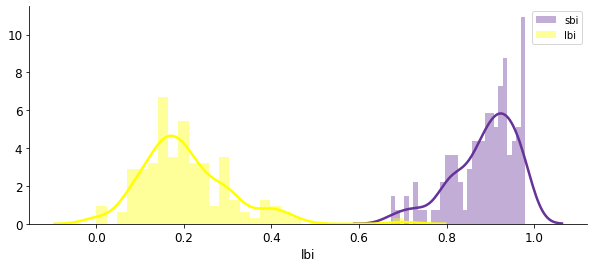

In [49]:
# Visualize distribution of lbi and sbi before normalization
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(song_data['sbi'], color='rebeccapurple', bins=30, label='sbi')
sns.distplot(song_data['lbi'], color='yellow', bins=30, label='lbi');
ax.legend();

In [50]:
song_data['lbi'] = minmax_scale(song_data['lbi'])
song_data['sbi'] = minmax_scale(song_data['sbi'])

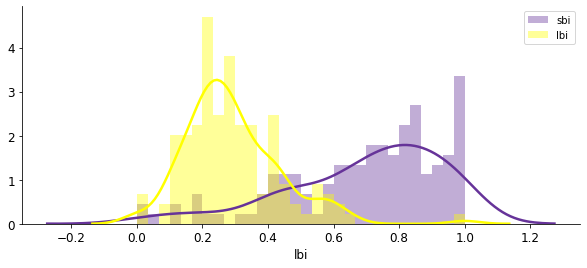

In [51]:
# Visualize distribution of lbi and sbi AFTER normalization
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(song_data['sbi'], color='rebeccapurple', bins=30, label='sbi')
sns.distplot(song_data['lbi'], color='yellow', bins=30, label='lbi');
ax.legend();

In [52]:
song_data.nlargest(1, 'lbi')

,title,uri,energy,valence,danceability,sbi,duration_sec,total_words,brutal_words,brutal_prop,lbi
116,puncture wound massacre,spotify:track:6tNy0SL7YeBrTJmDwTjnzA,0.993,0.0377,0.311,0.992594,101.2,142,71,0.5,1.0


We have one massive outlier in the LBI, somewhat distorting the whole distribution (pushing the rest of the scores down). But hey, that's the game. And given the songs short duration (1:31 min) and 'unompromising' lyrical catchiness it well deserves the top spot. (This will - spoiler - most probably secure it the overall title as most brutal Cannibal Corpse song ...)

In [53]:
print(lyrics_dict['puncture wound massacre'])



Stab, hack, slash, kill
Stab, hack, slash, kill
Stab, hack, slash, kill
Stab, hack, slash, kill
Die, butcher
Rage of hate
Stab, hack, slash, kill
Stab, hack, slash, kill
Stab, hack, slash, kill
Stab, hack, slash, kill

Kick down the door in barbaric rage
Frantically slashing all who stand in my way
Stab another face, slit another throat
My intention is to mutilate them
People are screaming it feeds my hate
Hack through the crowd blood is splashing on my face
I only see red, rage exploding
Two knives, one mind, that hate has broken

Stabbing, disfigure, knives puncture
Blood gushing from their wounds
Rivers run deep red
Down faces of people in the room
Bodies are heaping they're dying
In seconds they were slain
Daggers in my hands are killing
This worthless piece of shit

Hate for them still drives my rage
My job is almost finished only one remains
In the corner terrified behind the grisly slaughter
Ill take my time on this last scum bag
Knife in stomach, hes not dead yet
Carving up h

## Calculate TBI

Let's simply take the average (arithmetic mean) of the two indexes. Since both indexes are on the same scale (they both range from 0 to 100), this would imply that the amount of anger in a song’s lyrics and a song’s sound equally determine the level of overall anger in that song. (In this case tough the SBI has somewhat higher scores and is favoured a little bit.)

$$Total Brutality Index = (0.5 * Sonic Brutality Index) + (0.5 * Lyrical Brutality Index)$$

In [54]:
song_data['TBI'] = (song_data['sbi'] * 0.5) + (song_data['lbi'] * 0.5)

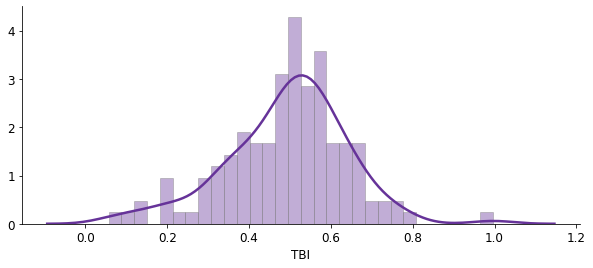

In [56]:
# Visualize distribution of lbi and sbi AFTER normalization
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(song_data['TBI'], color='rebeccapurple', bins=30, label='TBI', hist_kws={'edgecolor': 'grey'});

In [57]:
song_data.nlargest(5, 'TBI')

,title,uri,energy,valence,danceability,sbi,duration_sec,total_words,brutal_words,brutal_prop,lbi,TBI
116,puncture wound massacre,spotify:track:6tNy0SL7YeBrTJmDwTjnzA,0.993,0.0377,0.311,0.992594,101.200,142,71,0.500000,1.000000,0.996297
84,dormant bodies bursting,spotify:track:0G074Tus7GLgG5Pr5IpsA0,0.997,0.0579,0.392,0.965317,120.333,83,52,0.626506,0.615943,0.790630
106,unite the dead,spotify:track:1pG92XKUDXo3FQxzqNaSGH,0.982,0.0954,0.194,0.878430,185.333,164,85,0.518293,0.653715,0.766072
112,crushing the despised,spotify:track:4g2XQt5ux2eO95D188I7nB,0.998,0.0422,0.478,0.993128,116.733,111,42,0.378378,0.512835,0.752982
47,pounded into dust,spotify:track:6jZQyjwjxG1neT2GapMsoz,0.989,0.1240,0.306,0.840230,136.626,112,60,0.535714,0.625951,0.733090


In [58]:
song_data.nsmallest(3, 'TBI')

,title,uri,energy,valence,danceability,sbi,duration_sec,total_words,brutal_words,brutal_prop,lbi,TBI
117,relentless beating,spotify:track:0ox3y11lj7cGdgS1uAsW02,0.988,0.493,0.176,0.113230,134.506,1,0,0.0,0.000000,0.056615
105,from skin to liquid,spotify:track:4kYLhsdj7PkuxcZlWuZMop,0.798,0.334,0.109,0.182543,330.266,1,0,0.0,0.000000,0.091272
60,murder worship,spotify:track:2PozhlQgFtj3bk38MsRrYK,0.972,0.534,0.261,0.000000,236.666,140,42,0.3,0.252951,0.126475


In [61]:
print(lyrics_dict['murder worship'])



Homage to our god, the act of killing bears us
Closer to his grace, beyond the void of darkness
Every drop of blood, a chance to deify us
Bring is to our lord our killings transcending
Convictions of violence, pure unrelenting

Devotion drips from my jagged blade
My righteous hate fuels unyielding rage
Sacramental slaughter of the faith
In the homicidal doctrine he creates

Decapitated heads adorn the holy altar
Kneeling at its base, we stare in veneration
Every single death, brought us closer to him
Take us to our lord our bloodlust evolving
Enshrining the bodies, evil emerging

Hate rips through flesh and bone
The dogma states that it must be done
We adhere to the holy text
More must die if we are to advance

Murder Worship
Murder Worship
Murder Worship
Murder Worship

Pray to our god
With blood we praise his epic acts of hate and homicidal glory, legendary murders
Trust in our lord
Leads us to kill in the same way that he did, sever all the heads in sacrificial splendor
He is clos